# Autoregressive Model Testing

## Notes for revision:
- Use ADF to determine if the data is stationary
- If the data is not stationary, use ACF， PACF to determine the difference
- AR(order, difference, moving average), start with order 1
- Issue: negative R^2 meaning the model is not converging

RMSE reduced by: 
- 13.19% by adding Bitcoin volitility in GDP AR prediction
- 10.86% by adding USD Coin volitility in GDP AR prediction


In [160]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML

In [161]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

## Testing all combinations

In [162]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP', 'IM', 'EX', 'CC', 'CC Monthly % Change']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin']
max_lag = 2
train_end = '2023-05-01'

results_list = []

In [163]:
# Difference the data
def adf_stationarize(df, col):
    df[col + '_diff'] = df[col].diff()
    return df[col + '_diff'].dropna()

In [164]:
def run_model(df, macro, asset):
    df_temp = df[[macro, asset]].dropna().copy()
# Create lagged asset volatility columns

    for lag in range(1, max_lag + 1):
        df_temp[f'{asset}_vol_lag{lag}'] = df_temp[asset].shift(lag)
    df_temp.dropna(inplace=True)
    
    adf_p = adfuller(df_temp[macro])[1]
    if adf_p > 0.05:
        macro_diff = macro + '_diff'
        df_temp[macro_diff] = df_temp[macro].diff()
        df_temp.dropna(inplace=True)
        target = df_temp[macro_diff]
    else:
        target = df_temp[macro]
    
    exog = df_temp[[f'{asset}_vol_lag{lag}' for lag in range(1, max_lag + 1)]]

    # Train/test split
    train_endog = target[:train_end]
    test_endog = target[train_end:]
    train_exog = exog[:train_end]
    test_exog = exog[train_end:]

    # AR model
    ar_model = SARIMAX(train_endog, order=(max_lag, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
    ar_result = ar_model.fit(disp=False)
    forecast_ar = ar_result.get_forecast(steps=len(test_endog))
    pred_ar = forecast_ar.predicted_mean

    # ARX model
    arx_model = SARIMAX(train_endog, exog=train_exog, order=(max_lag, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
    arx_result = arx_model.fit(disp=False)
    forecast_arx = arx_result.get_forecast(steps=len(test_endog), exog=test_exog)
    pred_arx = forecast_arx.predicted_mean

    # Metrics
    metrics = [
        {
            'Model': 'AR',
            'Macro': macro,
            'Asset': asset,
            'MAE': mean_absolute_error(test_endog, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_ar)),
            'R2': r2_score(test_endog, pred_ar)
        },
        {
            'Model': 'ARX',
            'Macro': macro,
            'Asset': asset,
            'MAE': mean_absolute_error(test_endog, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog, pred_arx)),
            'R2': r2_score(test_endog, pred_arx)
        }
    ]

    return metrics

In [165]:
# Run through all combinations
for macro in macro_list:
    for asset in asset_list:
        try:
            result_metrics = run_model(df.copy(), macro, asset)
            results_list.extend(result_metrics)
        except Exception as e:
            print(f"Error with {macro}-{asset}: {e}")
            continue

# Final table
results_df = pd.DataFrame(results_list)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
display(HTML(results_df.to_html(max_rows=1000, max_cols=10, notebook=True, escape=False)))

/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

,Model,Macro,Asset,MAE,RMSE,R2
0,AR,LFPR,Bitcoin,0.0667,0.1069,0.0000
1,ARX,LFPR,Bitcoin,0.0746,0.1083,-0.0266
2,AR,LFPR,Tether,0.0667,0.1069,0.0000
3,ARX,LFPR,Tether,0.0692,0.1069,-0.0004
4,AR,LFPR,Litecoin,0.0667,0.1069,0.0000
5,ARX,LFPR,Litecoin,0.0712,0.1071,-0.0043
6,AR,LFPR,XRP,0.0667,0.1069,0.0000
7,ARX,LFPR,XRP,0.0724,0.1052,0.0319
8,AR,LFPR,Ethereum,0.0667,0.1069,0.0000
9,ARX,LFPR,Ethereum,0.0748,0.1050,0.0354


# Combinations Where Adding Asset Data Improves the Model

In [166]:
# Assuming you already have this DataFrame from earlier:
# results_df columns: ['Model', 'Macro', 'Asset', 'MAE', 'RMSE', 'R2']

# Reshape for comparison
df_wide = results_df.pivot_table(
    index=['Macro', 'Asset'],
    columns='Model',
    values=['MAE', 'RMSE', 'R2']
)

df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Define better = lower RMSE, lower MAE, higher R²
df_wide['ARX_better_RMSE'] = df_wide['RMSE_ARX'] < df_wide['RMSE_AR']
df_wide['ARX_better_MAE'] = df_wide['MAE_ARX'] < df_wide['MAE_AR']
df_wide['ARX_better_R2']  = df_wide['R2_ARX']  > df_wide['R2_AR']

# Filter: only combinations where ARX is better by **all** metrics
better_all = df_wide[
    (df_wide['ARX_better_RMSE']) &
    (df_wide['ARX_better_MAE']) &
    (df_wide['ARX_better_R2'])
]

# Display results
if not better_all.empty:
    print("Combinations where ARX (with asset) outperforms AR on all metrics:")
    display(better_all[['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'RMSE_AR', 'RMSE_ARX', 'R2_AR', 'R2_ARX']])
else:
    print("No combination found where ARX beats AR across MAE, RMSE, and R².")

# If you're interested in partial wins (e.g. just RMSE or R²), you can display those too:
print("Combinations where ARX has lower RMSE:")
display(df_wide[df_wide['ARX_better_RMSE']][['Macro', 'Asset', 'RMSE_AR', 'RMSE_ARX', 'R2_AR', 'R2_ARX']])


Combinations where ARX (with asset) outperforms AR on all metrics:


,Macro,Asset,MAE_AR,MAE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX
16,CPI,Bitcoin,0.7282,0.6943,0.9660,0.8124,-0.6181,-0.1443
18,CPI,Dogecoin,0.7282,0.6565,0.9660,0.8284,-0.6181,-0.1899
20,CPI,Litecoin,0.7282,0.7131,0.9660,0.8477,-0.6181,-0.2460
21,CPI,Tether,0.7282,0.7252,0.9660,0.8538,-0.6181,-0.2641
23,CPI,XRP,0.7282,0.6985,0.9660,0.8319,-0.6181,-0.2000


Combinations where ARX has lower RMSE:


,Macro,Asset,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX
16,CPI,Bitcoin,0.9660,0.8124,-0.6181,-0.1443
17,CPI,Cardano,0.9665,0.9547,-0.6195,-0.5805
18,CPI,Dogecoin,0.9660,0.8284,-0.6181,-0.1899
19,CPI,Ethereum,0.9660,0.9325,-0.6181,-0.5078
20,CPI,Litecoin,0.9660,0.8477,-0.6181,-0.2460
21,CPI,Tether,0.9660,0.8538,-0.6181,-0.2641
22,CPI,USD Coin,0.9591,0.9140,-0.5948,-0.4484
23,CPI,XRP,0.9660,0.8319,-0.6181,-0.2000
24,EX,Bitcoin,26.9630,24.3766,-0.3416,-0.0966
27,EX,Ethereum,26.9630,24.2092,-0.3416,-0.0816


## Plotting Individual Conbination

In [167]:
macro = 'GDP'
asset = 'USD Coin'
train_end = '2023-05-01'

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01405D+00    |proj g|=  4.81197D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   4.812D-06   8.014D+00
  F =   8.0140478462384586     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.0

 This problem is unconstrained.
 This problem is unconstrained.


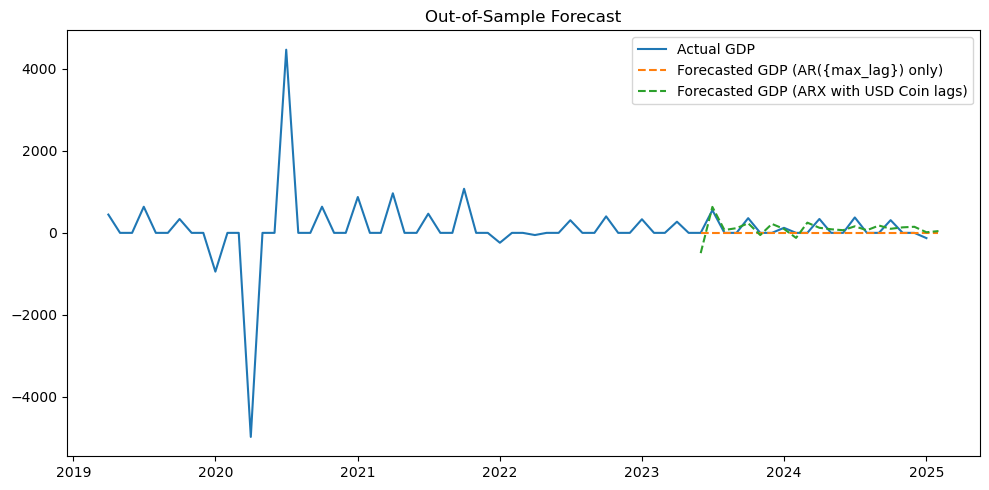

AR model test set evaluation:
  MAE:  104.2381
  RMSE: 197.5694
  R²:   -0.2772

ARX model test set evaluation:
  MAE:  232.5108
  RMSE: 278.3448
  R²:   -1.5351


In [168]:
df_temp = df[[macro, asset]].dropna().copy()
# Create lagged asset volatility columns

for lag in range(1, max_lag + 1):
    df_temp[f'{asset}_vol_lag{lag}'] = df_temp[asset].shift(lag)
df_temp.dropna(inplace=True)

adf_p = adfuller(df_temp[macro])[1]
if adf_p > 0.05:
    macro_diff = macro + '_diff'
    df_temp[macro_diff] = df_temp[macro].diff()
    df_temp.dropna(inplace=True)
    target = df_temp[macro_diff]
else:
    target = df_temp[macro]

exog = df_temp[[f'{asset}_vol_lag{lag}' for lag in range(1, max_lag + 1)]]

# Train/test split
train_endog = target[:train_end]
test_endog = target[train_end:]
train_exog = exog[:train_end]
test_exog = exog[train_end:]

# 1. AR model (GDP only), with AR order = max_lag
model_macro = SARIMAX(train_endog,
                    order=(max_lag, 0, 0),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
result_macro = model_macro.fit()

# 2. ARX model (GDP + lagged Bitcoin volatility)
model_withCryp = SARIMAX(train_endog,
                         exog=train_exog,
                         order=(max_lag, 0, 0),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
results_withCryp = model_withCryp.fit()
'''
print("=== AR Model Summary ===")
print(result_macro.summary())

print("\n=== ARX Model Summary ===")
print(results_withCryp.summary())
'''

# Forecast
forecast_1 = result_macro.get_forecast(steps=len(test_endog))
forecast_2 = results_withCryp.get_forecast(steps=len(test_endog), exog=test_exog)

predicted_mean1 = forecast_1.predicted_mean
predicted_mean2 = forecast_2.predicted_mean

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(target, label='Actual ' + macro)
plt.plot(predicted_mean1, label=f'Forecasted ' + macro+ ' (AR({max_lag}) only)', linestyle='--')
plt.plot(predicted_mean2, label=f'Forecasted {macro} (ARX with {asset} lags)', linestyle='--')
plt.title("Out-of-Sample Forecast")
plt.legend()
plt.tight_layout()
plt.show()


# Printing stats 
mae_ar = mean_absolute_error(test_endog, predicted_mean1)
rmse_ar = np.sqrt(mean_squared_error(test_endog, predicted_mean1))
r2_ar = r2_score(test_endog, predicted_mean1)

mae_arx = mean_absolute_error(test_endog, predicted_mean2)
rmse_arx = np.sqrt(mean_squared_error(test_endog, predicted_mean2))
r2_arx = r2_score(test_endog, predicted_mean2)

print("AR model test set evaluation:")
print(f"  MAE:  {mae_ar:.4f}")
print(f"  RMSE: {rmse_ar:.4f}")
print(f"  R²:   {r2_ar:.4f}\n")

print("ARX model test set evaluation:")
print(f"  MAE:  {mae_arx:.4f}")
print(f"  RMSE: {rmse_arx:.4f}")
print(f"  R²:   {r2_arx:.4f}")

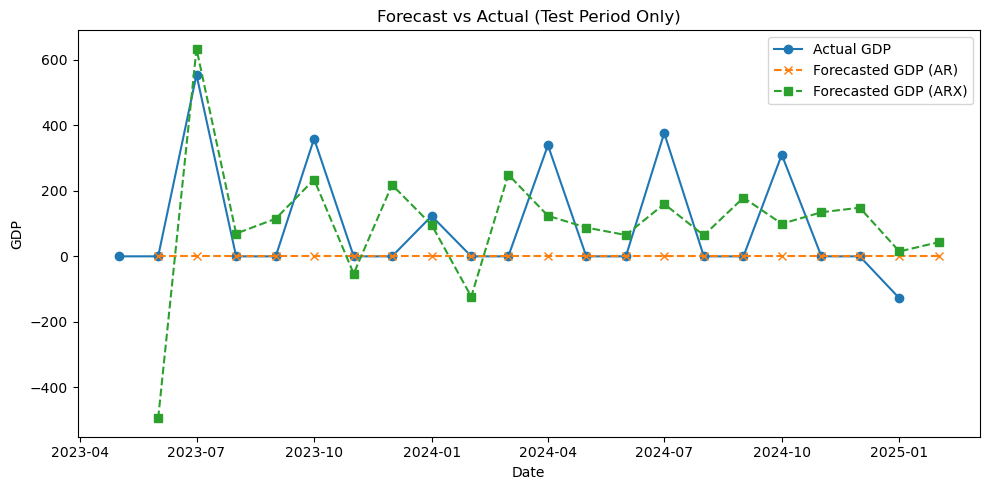

In [169]:
# Plot only test data with forecasts
plt.figure(figsize=(10, 5))
plt.plot(test_endog, label='Actual ' + macro, marker='o')
plt.plot(predicted_mean1, label=f'Forecasted {macro} (AR)', linestyle='--', marker='x')
plt.plot(predicted_mean2, label=f'Forecasted {macro} (ARX)', linestyle='--', marker='s')
plt.title("Forecast vs Actual (Test Period Only)")
plt.xlabel("Date")
plt.ylabel(macro)
plt.legend()
plt.tight_layout()
plt.show()


# Seasonal ARIMA Testing 

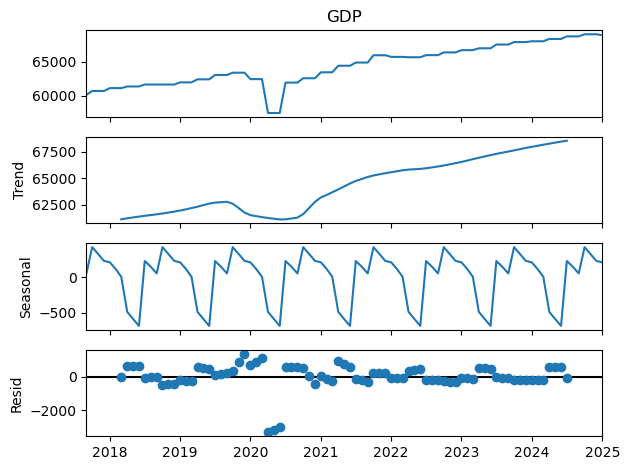

In [170]:
result = seasonal_decompose(df[macro], model='additive', period=12)  # Assuming monthly data
result.plot()
plt.show()

In [171]:
# Seasonal period, e.g. 12 for monthly data
s = 12  
p = d = q = range(0, 2)  # try 0 or 1 for each
seasonal_pdq = list(itertools.product(p, d, q))

best_aic = float('inf')
best_order = None
best_seasonal_order = None

for param in itertools.product(p, d, q):
    for seasonal_param in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df[macro],
                                            order=param,
                                            seasonal_order=(seasonal_param[0], seasonal_param[1], seasonal_param[2], s),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue

print(f'Best SARIMA{best_order}x{best_seasonal_order}{s} - AIC:{best_aic}')


/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best SARIMA(1, 1, 1)x(1, 1, 1)12 - AIC:1046.4702242324925


/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [172]:
(p, d, q) = (1, 0, 1)
(P, D, Q, s) = (0, 1, 1, 12)

model = SARIMAX(train_endog,
                exog=train_exog,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),  # s = 12 for monthly data
                enforce_stationarity=False,
                enforce_invertibility=False)
result = model.fit()

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00649D+01    |proj g|=  5.91208D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     31      2     0     0   1.429D+06   5.757D+00
  F =   5.7572696669046604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


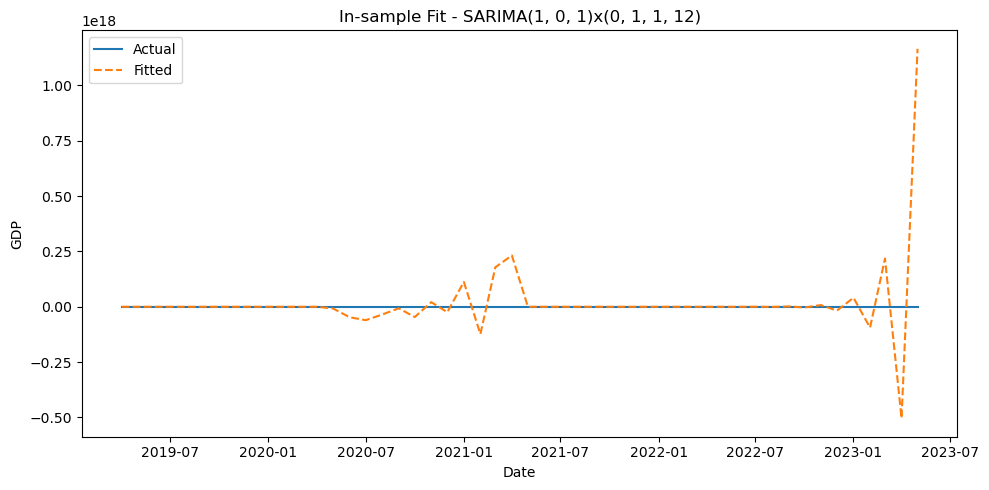

In [173]:
# In-sample prediction
fitted_values = result.fittedvalues

plt.figure(figsize=(10, 5))
plt.plot(train_endog, label='Actual')
plt.plot(fitted_values, label='Fitted', linestyle='--')
plt.title(f"In-sample Fit - SARIMA{(p, d, q)}x{(P, D, Q, s)}")
plt.xlabel("Date")
plt.ylabel(macro)
plt.legend()
plt.tight_layout()
plt.show()
